Il dato proviene dal notebook ANALISI_ARTICOLI.ipynb, "df_with_engagement_differences.csv", che passa in rassegna gli articoli con focus sulle differenze di performance rispetto al benchmark di riferimento (la media degli articoli pubblicati quello stesso giorno)

L'idea è usare questi dati per aiutare il team creativo a creare articoli performanti, ingaggianti o che generano traffico.

In [5]:
# Import pandas and read nb_processed_data.csv from parent folder

import pandas as pd
import os

# Get the current working directory
current_dir = os.getcwd()
print(f"Current Directory: {current_dir}")

# Construct the path to the CSV file in the parent directory
csv_file_path = os.path.join("..", 'df_with_engagement_differences.csv')

data = pd.read_csv(csv_file_path, sep=",", encoding="latin-1")

data

Current Directory: c:\Users\manuel.deluzi\OneDrive - Havas\Projects\personali\taxi_drivers\notebooks\analisi_articoli_pubblicati\Analisi di contenuto


,date,title,link,category,pagepath,pubdate,post_views_count,views,publication_tags,average engagement time per active user,active users,views per active user,date_active users,daily_median_benchmark_active users,date_average engagement time per active user,daily_median_benchmark_average engagement time per active user,diff_with_daily_benchmark_active users,diff_with_daily_benchmark_average engagement time per active user,active_users_bucket,engagement_bucket
0,2024-04-09,"Cattivissimo me di Pierre Coffin, Chris Renaud...",https://www.taxidrivers.it/67349/film-da-veder...,Guide e Film da Vedere,/67349/film-da-vedere/cattivissimo-me-di-pierr...,2024-04-09 05:00:09+00:00,2635,10.0,"Cattivissimo me, Chris Renaud, Dana Gaier, Els...",10.666667,6.0,1.666667,2024-04-09,13.0,2024-04-09,21.857143,-7.0,-11.190476,Basso,Molto Basso
1,2024-04-09,Pusher di Nicolas Winding Refn,https://www.taxidrivers.it/77452/film-da-veder...,Guide e Film da Vedere,/77452/film-da-vedere/stasera-alle-2335-rai-mo...,2024-04-09 05:00:24+00:00,2958,15.0,"Kim Bodnia, Laura Drasbæk, Mads Mikkelsen, Nic...",13.200000,15.0,1.000000,2024-04-09,13.0,2024-04-09,21.857143,2.0,-8.657143,Medio,Basso
2,2024-04-09,Missing - Scomparso,https://www.taxidrivers.it/80104/film-da-veder...,Guide e Film da Vedere,/80104/film-da-vedere/stasera-alle-2330-la7-mi...,2024-04-09 05:00:57+00:00,4170,13.0,"Costa-Gavras, Jack Lemmon, Melanie Mayron, Mis...",12.555556,9.0,1.444444,2024-04-09,13.0,2024-04-09,21.857143,-4.0,-9.301587,Basso,Basso
3,2024-04-09,I migliori podcast italiani sul cinema che non...,https://www.taxidrivers.it/359630/magazine-2/i...,Speciali e Magazine,/359630/magazine-2/i-migliori-podcast-italiani...,2024-04-09 07:01:36+00:00,2389,588.0,"Cinema, Enrico Magrelli, Hollywood Party, PANO...",49.848411,409.0,1.437653,2024-04-09,13.0,2024-04-09,21.857143,396.0,27.991268,Molto Alto,Molto Alto
4,2024-04-09,'Another End' Conversazione con Piero Messina,https://www.taxidrivers.it/362834/interviews/c...,Interviste,/362834/interviews/conversation/another-end-co...,2024-04-09 06:15:04+00:00,594,64.0,"Another End, Carlo Cerofolini, CONVERSATIONS, ...",20.675676,37.0,1.729730,2024-04-09,13.0,2024-04-09,21.857143,24.0,-1.181467,Molto Alto,Medio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6967,2025-04-08,"L'invenzione del ""cutoff"" spiegata da Artisti ...",https://www.taxidrivers.it/436725/latest-news/...,News,/436725/latest-news/l-invenzione-del-cutoff-sp...,2025-04-08 21:28:08+00:00,82,7.0,"Alberto Molinari, Alessandro Riceci, Artisti 7...",41.000000,5.0,1.400000,2025-04-08,7.0,2025-04-08,18.235294,-2.0,22.764706,Basso,Molto Alto
6968,2025-04-08,Il ritorno trionfale di Tom Cruise a Cannes co...,https://www.taxidrivers.it/436726/latest-news/...,News,/436726/latest-news/il-ritorno-trionfale-di-to...,2025-04-08 20:54:32+00:00,87,4.0,"Festival di Cannes, Mission Impossible ? The F...",9.750000,4.0,1.000000,2025-04-08,7.0,2025-04-08,18.235294,-3.0,-8.485294,Basso,Basso
6969,2025-04-08,'Come vendere droga online (in fretta)': dispo...,https://www.taxidrivers.it/436743/trailers/com...,Trailers,/436743/trailers/come-vendere-droga-online-in-...,2025-04-08 22:50:02+00:00,234,NaN,"Come vendere droga online (in fretta), lena kl...",NaN,NaN,NaN,2025-04-08,7.0,2025-04-08,18.235294,NaN,NaN,NaN,NaN
6970,2025-04-08,"Da Gabriella Carlucci ai Manetti Bros, i due g...",https://www.taxidrivers.it/436750/festival-di-...,Festival di Cinema,/436750/festival-di-cinema/eventi/da-gabriella...,2025-04-08 23:57:27+00:00,173,18.0,"Epica Etica Estetica dell?Immaginario, Gabriel...",28.666667,15.0,1.200000,2025-04-08,7.0,2025-04-08,18.235294,8.0,10.431373,Alto,Alto


## Predire un output a partire da un LLM (esempio text-to-CTR Bert-based ML model)

Partiamo dalle cose semplici, analizzando una variabile alla volta.
Per prima cosa partiamo dal titolo. 

Per far questo faremo affidamento sugli embeddings.

BERT: ottimo per interpretare assegnare alle parole un significato in base al contesto in cui si trovano.

CASI D'USO DA PRENDERE A RIFERIMENTO
https://arxiv.org/pdf/2108.08226 

L'idea è costruire un modello text-diff_with_benchmark: Predire quanto un articolo performerà rispetto al benchmark a partire dal titolo. Nel caso d'uso linkato in precedenza si fa riferimento a un modello text-CTR implementato da Verizon Media per  
aiutare agli advertiser a creare il testo per le creatività.

Fine-tuning di BERT con le differenze rispetto al benchmark estratte dallo storico degli articoli pubblicati.
Punto di partenza: Sentence-BERT model.
plus weak-labeling method, per tener conto di fattori esterni (quali la categoria di appartenenza dell'articolo) che potrebbero
avere un impatto sul traffico indipendente dal titolo.

*For example, ‘Online store for shoes!’ and ‘Online store for pets!’ are both
online shopping ads and maybe be inferred as similar by a generic
textual-similarity-model, but can be differentiated after ad-specific fine tuning based on our weak labeling method.*

In chiave teorica sarebbe anche possibile implementare un metodo di suggerimento di titoli. Nel paper si suggerisce un 
approccio basato sul vicinato semantico dei titoli.

Metriche di valutazione utilizzate:
* AUC
* Precision@5 e Precision@1

Modelli di baseline (rispetto ai quali valutare il modello):
* (unsupervised) TD-IDF
* word2vec
* SBERT (Sentence-BERT)

Nel paper si discute anche della possibilità di estendere il modello text-CTR a lingue non inglese (Taiwanese e Cantonese)

*In an online test from mid-January to mid-February 2021, 25.12%
of DSP advertisers (with English ads) seeing recommendations changed their ads based on ad text seen in TSI suggestions, and such adopters collectively observed a 27% CTR lift
compared to non-adopters who were exposed to recommendations.* 

Dettagli sul modello di predizione del CTR: 

*CTR prediction model. We propose a BERT [5] based CTR prediction model which takes in the ad text (e.g., concatenation of ad title,
ad description, and call to action in the case of Verizon Media advertisers), and the publisher (for which CTR is to be estimated). We
take the pre-trained uncased BERT base model released by Google
[5], and fine-tune it with ad impressions and clicks data. Details of
the CTR prediction model are in Section 4.*

Dettagli sul modello di retrieval di testi ad simili:  

*For similar ads retrieval, we assume a
pool of existing ads (∼ 50𝑘 for our experiments). Each ad in the pool
has its original ad text, its anonymized version (without references
to a brand), and the associated pCTR (predicted click-through rate,
computed in advance from the CTR prediction model). The goal of
similar ads retrieval is to find top 𝑘 relevant (semantically similar)
ads from the pool, given an input ad text. In this paper, we propose a
semantic-ad-similarity model which produces ad text embeddings,
and compares two ads using cosine similarity between their ad
text embeddings. Our semantic-ad-similarity model is based on
sentence-BERT [18] fine tuned with weak similarity labels from
the ads data (additional details in Section 5).*

TSI:    

*The TSI block needs the results for CTR prediction and
similar ads retrieval for a given input ad. Intuitively, the TSI block
checks whether the input ad’s pCTR is low compared to pCTRs of
other ads in its semantic neighborhood. If there are a significant
number of superior ads (above a predefined pCTR difference threshold) in its neighborhood, the input ad is labeled weak (0), else it is
labeled strong (1). In addition, for a weak input ad, anonymized
versions of superior ads are shown as improvement suggestions.
Additional details on the TSI logic are in Section 6.*


Se voglio, posso concatenare il titolo con altre stringhe non strutturate. Per le variabili categoriche 

**Roadmap**: strada per, ha un punto di partenza. Ha una destinazione.

La destinazione coincide con un **obiettivo**
Questo obiettivo lo perseguiamo automatizzando con un modello.
Il modello è il mezzo attraverso cui si raggiunge l'obiettivo.

**Modello** significa prendere qualcosa che replica la forma di qualcos'altro. 
In ambito scientifico, un modello è un insieme di teorie che descrive aspetti scelti di un fenomeno (nel nostro caso il risultato
delle headlines d'articolo) in modo da permettere previsioni sulla base di quegli aspetti. 
E' una rappresentazioni (ce ne possono essere molte) di una parte del mondo reale (il fatto che alcuni titoli performano meglio di altri).

Con un modello stiamo in sostanza delegando il processo creativo (è questa una delle rivoluzioni dell'AI).
[breve storia dell'AI nella generazione di testi, come si è passati a algoritmi in grado di interpretare semanticamente il testo, fare un esempio].

Tornando agli obiettivi: studiamo il risultato dei titoli rispetto a una performance d'interesse, cerchiamo di costruire un 
modello di testo in grado di replicare quel successo, e chiediamo al modello di generare titoli in autonomia in grado di 
replicare i titoli di successo. 

Destinazione, caso d'uso reale. Sono un titolista e chiedo all'AI:
"Questo è un titolo per un articoli di notizie che [etc. etc. se voglio estendere il contesto con informazioni ulteriori].   
Dimmi se performerà meglio rispetto al benchmark (mediana visualizzazioni o utenti attivi a seconda caso generato nello stesso giorno di pubblicazione)"

Modelli open-source, su HuggingFace, BERT, **Sentence-BERT**.
Differenza rispetto ad altri modelli più semplici: Logistic Regression, Naive Bayes

BERT è bidirezionale, meccanismi auto-attentivi, prende in considerazione l'intero contesto in cui la parola compare, 
la macchina è in grado di interprentare la semantica del testo (esempio).

Rispetto a BERT, Sentence-BERT codifica non le singole parole, ma frasi intere, adeguato allo use case dei titoli.

Costruire dei modelli che siano tagliati sulla parte di realtà che vediamo in Taxi Drivers: quali titoli performano meglio
rispetto a quanto visto su Taxi Drivers. Allenando il modello con gli articoli di Taxi Drivers questo sarà in grado di 
contestualizzare i testi generati: quali sono i migliori testi per ottimizzare l'obiettivo editoriale prendendo in considerazione
l'universo di articoli Taxi Drivers. L'universi di testi generabili è in grado di incorporare aspetti unici del sito:
* tone of voice 
* gusti del pubblico
* argomenti trattati
* etc...

[E' possibile inserire esplicitamente queste informazioni nell'input di training?]

C'è poi il contesto, codificabile come variabile one-hot. Nel nostro caso la categoria di appartenenza degli articoli. 
Attraverso il contesto, il modello genera titoli ottimizzati a seconda della categoria del titolo.


Una definizione di **fine-tuning**: aggiustare i pesi del modello.


Il focus è sull'**automazione** (digital business transformation, creatività data-driven, ottimizzazione).


Si parte da quel che si ha:
* the dataset: articoli pubblicati su taxi drivers. Quante visualizzazioni ha generato (views), quanto traffico in termini di persone fisiche (utenti attivi). 

Modello predittivo:
1. Preparazione del dato
    - Aspetto da concatenare insieme al titolo?
    - Contesto (nel nostro caso "categoria di appartenenza degli articoli"). 
2. Fine-tuning Sentence-BERT

* weak labeling

Architettura del modello predittivo:

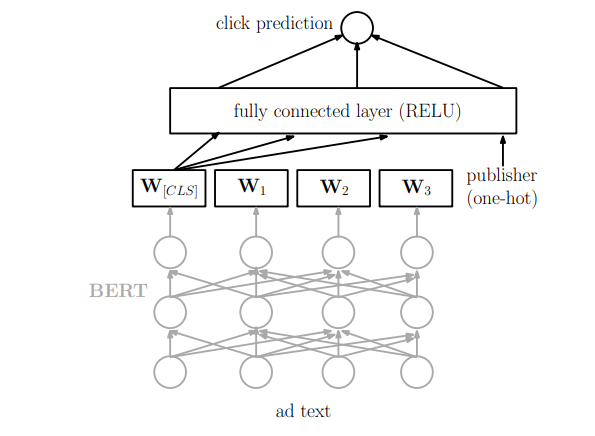


Modello di raccomandazione:
Lo step successivo. Capire se un titolo fornito in input per una certa categoria è migliorabile, e in quel caso consigliare un titolo per quella categoria.
Esempio use case. Sei un titolista...


Output finale, punteggio che riassume quanto quel titolo è competitivo (chiamato TSI).


Modello predittivo
Sentence-BERT, funzione/classe 


Il modello proposto è il seguente: "Text-to-Traffic-Diff Prediction"

(BERT + Category Embedding) for Traffic Delta Prediction

Traffic è definito in termini di utenti attivi. 
Il target del modello è il delta del traffico rispetto al benchmark dei titoli degli articoli pubblicati lo stesso giorno.


**📥 Inputs:**
Ad Title (title) – text input to Sentence-BERT (Italian)

Category (category) – One-hot encoded vector (e.g., "News", "Trailers", etc.)


**Model**
Sentence-Bert (nickprock/sentence-bert-base-italian-uncased)

## How we will work

1. Prepare the data: 
    * Use ETL that merges google analytics 4 to wordpress data
    * Takes the data, and computes how much articles are above or below average in terms of active users, based on 
        articles that have been published that same day. Thus, return a label for each equal to 1 if above average, else 0.
    * Embed Integrate ETL with later passage, returning final ETL that attaches to ML operations.


2. ML operations 
They are executed in Google Colab through manually importing results from previous step 

In [ ]:
# Prepare the data to pass to colab

ml_dataset = data[['title', 'category', 'diff_with_daily_benchmark_active users']]
ml_dataset.fillna(0, inplace=True)



C:\Users\manuel.deluzi\AppData\Local\Temp\ipykernel_22416\1336234414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_dataset.fillna(0, inplace=True)
C:\Users\manuel.deluzi\AppData\Local\Temp\ipykernel_22416\1336234414.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_dataset['category_encoded'] = le.fit_transform(ml_dataset['category'])


category_encoded
6     2301
3     1783
7      796
11     466
12     465
8      375
5      243
10     236
0      122
9       72
4       61
2       39
13       7
1        6
Name: count, dtype: int64

In [ ]:
# https://chatgpt.com/c/68090074-71a4-8000-8f69-fd1a20cd1592




,title,link,category,pagepath,pubdate,post_views_count,views,publication_tags,average engagement time per active user,active users,views per active user,_yoast_wpseo_focuskw,_yoast_wpseo_metadesc,_yoast_wpseo_linkdex,content
0,"Cattivissimo me di Pierre Coffin, Chris Renaud...",https://www.taxidrivers.it/67349/film-da-veder...,Guide e Film da Vedere,/67349/film-da-vedere/cattivissimo-me-di-pierr...,2024-04-09 05:00:09+00:00,2635,10.0,"Cattivissimo me, Chris Renaud, Dana Gaier, Els...",10.666667,6.0,1.666667,Cattivissimo me Pierre Coffin,Cattivissimo me è un film d'animazione del 201...,56.0,"<p style=""text-align: justify;""><em><strong>Ca..."
1,Pusher di Nicolas Winding Refn,https://www.taxidrivers.it/77452/film-da-veder...,Guide e Film da Vedere,/77452/film-da-vedere/stasera-alle-2335-rai-mo...,2024-04-09 05:00:24+00:00,2958,15.0,"Kim Bodnia, Laura Drasbæk, Mads Mikkelsen, Nic...",13.200000,15.0,1.000000,Pusher,Pusher - L'inizio (Pusher) è un film del 1996 ...,78.0,"<p style=""text-align: justify;""><em><strong>Pu..."
2,Missing - Scomparso,https://www.taxidrivers.it/80104/film-da-veder...,Guide e Film da Vedere,/80104/film-da-vedere/stasera-alle-2330-la7-mi...,2024-04-09 05:00:57+00:00,4170,13.0,"Costa-Gavras, Jack Lemmon, Melanie Mayron, Mis...",12.555556,9.0,1.444444,Missing Costa-Gavras,Missing - Scomparso (Missing) è un film del 19...,67.0,"<p style=""text-align: justify;""><em><strong>Mi..."
3,I migliori podcast italiani sul cinema che non...,https://www.taxidrivers.it/359630/magazine-2/i...,Speciali e Magazine,/359630/magazine-2/i-migliori-podcast-italiani...,2024-04-09 07:01:36+00:00,2389,588.0,"Cinema, Enrico Magrelli, Hollywood Party, PANO...",49.848411,409.0,1.437653,Podcast,Un vademecum sugli otto migliori podcast cinem...,72.0,Il podcast sta alla radio come lo streaming st...
4,'Another End' Conversazione con Piero Messina,https://www.taxidrivers.it/362834/interviews/c...,Interviste,/362834/interviews/conversation/another-end-co...,2024-04-09 06:15:04+00:00,594,64.0,"Another End, Carlo Cerofolini, CONVERSATIONS, ...",20.675676,37.0,1.729730,piero messina,Con 'Another End' Piero Messina utilizza l'ess...,79.0,Inserito nel concorso ufficiale dell'ultima ed...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6967,"L'invenzione del ""cutoff"" spiegata da Artisti ...",https://www.taxidrivers.it/436725/latest-news/...,News,/436725/latest-news/l-invenzione-del-cutoff-sp...,2025-04-08 21:28:08+00:00,82,7.0,"Alberto Molinari, Alessandro Riceci, Artisti 7...",41.000000,5.0,1.400000,Cutoff,"In rete il video di Artisti 7607, che spiega c...",71.0,Cos’è il <strong>cutoff</strong>? Le piattafor...
6968,Il ritorno trionfale di Tom Cruise a Cannes co...,https://www.taxidrivers.it/436726/latest-news/...,News,/436726/latest-news/il-ritorno-trionfale-di-to...,2025-04-08 20:54:32+00:00,87,4.0,"Festival di Cannes, Mission Impossible – The F...",9.750000,4.0,1.000000,Tom Cruise Cannes,Il Re di Hollywood Tom Cruise tornerà a Cannes...,74.0,<strong>Tom Cruise</strong> è pronto a elettri...
6969,'Come vendere droga online (in fretta)': dispo...,https://www.taxidrivers.it/436743/trailers/com...,Trailers,/436743/trailers/come-vendere-droga-online-in-...,2025-04-08 22:50:02+00:00,234,NaN,"Come vendere droga online (in fretta), lena kl...",NaN,NaN,NaN,come vendere,La serie tv tedesca di successo firmata Netfli...,75.0,"E' finalmente disponibile su <a href=""https://..."
6970,"Da Gabriella Carlucci ai Manetti Bros, i due g...",https://www.taxidrivers.it/436750/festival-di-...,Festival di Cinema,/436750/festival-di-cinema/eventi/da-gabriella...,2025-04-08 23:57:27+00:00,173,18.0,"Epica Etica Estetica dell’Immaginario, Gabriel...",28.666667,15.0,1.200000,Epica Etica Estetica,Epica Etica Estetica dell’Immaginario è la due...,59.0,Come si sta evolvendo lo scenario artistico cu...
